In [1]:
import Pkg
Pkg.instantiate()

In [2]:
import Base: +, *
using Flux
import Flux: params
using Flux.Optimise
using LinearAlgebra
using Plots
import ProgressMeter
import ProgressMeter: @showprogress
PM = ProgressMeter
PM.ijulia_behavior(:clear)
using Statistics
import Random: seed!
using CUDA

# Aim and Scope

This notebook uses Deep Reinforcement Learning. This means that we combine two techniques that we have seen before:
 
 + Neural Networks to Parametrize our approximation of the Q-function and our approximation of the Optimal Policy
 + Q-learning to define learning objectives for tuning the parameters of our Neural Networks

The overall objective when defining what we mean by Q-learning, is to find an iterative procedure that leads to a (nearly-) optimal policy. Q-learning uses two separate nonlinear functions.

 + The Q-function, or the state-action-value-function, that estimates the future value (or cost) of choosing a certain action in a certain state.
 + The policy, striving to select the best possible action given a state.

# Rocket Landing

In [3]:
seed!(17)

Random.TaskLocalRNG()

We used approximations for both the policy and Q-function earlier, for the rocket landing example, and we used optimization to find good parameters for both the Q-function and the policy, which were second and first order polynomials, respectively.

Now, we will try to solve the same problem in the same way, but this time we will use neural networks instead of polynomials.

We first define our neural network structure 

In [4]:
leakyrelu(x; a=0.1) = max(x, a*x)

struct Net
    layer_sizes :: Vector{Int64}
    As :: Vector{Matrix{Float64}}
    bs :: Vector{Vector{Float64}}
    a :: Float64
end

function Net(layer_sizes; eps = 1e-2, a=0.1)
    As = []
    bs = []
    for (n_in, n_out) in zip(layer_sizes[1:end-1], layer_sizes[2:end])
        A = eps*randn(n_out, n_in)
        push!(As, A)
        b = eps*randn(n_out)
        push!(bs, b)
    end
    Net(layer_sizes, As, bs, a)
end

(*)(x :: Number, n :: Net) = Net(n.layer_sizes, x.*n.As, x.*n.bs, n.a)

function (+)(n :: Net, m :: Net) 
    @assert n.layer_sizes == m.layer_sizes
    @assert n.a == m.a
    
    Net(n.layer_sizes, n.As .+ m.As, n.bs .+ m.bs, n.a)
end

params(net :: Net) = params(net.As..., net.bs...)

function (net::Net)(x)
    for (A, b) in zip(net.As[1:end-1], net.bs[1:end-1])
        x = A*x+b
        x = leakyrelu.(x, a=net.a)
    end
    for (A, b) in zip(net.As[end:end], net.bs[end:end])
        x = A*x+b
    end
    x
end

In [5]:
net = Net([2, 10, 10, 1])
net([1, 2])

1-element Vector{Float64}:
 -0.010996579636279107

In [6]:
grads = gradient(() -> only(net([1.0, 2.0])), params(net))
@show grads.grads[net.As[1]]
@show grads.grads[net.bs[end]];

grads.grads[net.As[1]] = [1.7197731935899058e-5 3.4395463871798115e-5; -1.2924326057557312e-6 -2.5848652115114623e-6; 8.917628971292199e-6 1.7835257942584397e-5; 5.718923625004189e-6 1.1437847250008377e-5; -1.2275018862798837e-5 -2.4550037725597674e-5; 0.00027265881012530533 0.0005453176202506107; 1.3692629422826307e-5 2.7385258845652614e-5; -0.00012697016009601922 -0.00025394032019203844; 9.21135160972358e-5 0.0001842270321944716; 1.58839210997043e-5 3.17678421994086e-5]
grads.grads[net.bs[end]] = [1.0]


Now, let's land a rocket. We copy our reinforcement learning approach from earlier.

In [7]:
cost(p :: Net, q_ref :: Net, moves; lambda = 0.1) = mean([only(q_ref(vcat(m.x, p(m.x)))) for m in moves]) + lambda * sum([ norm(A)^2 for A in p.As ])
cost(q :: Net, q_ref :: Net, p_ref :: Net, moves; α = 0.95, lambda = 0.1) = mean([ (m.sc + α*only(q_ref(vcat(m.x₊, p_ref(m.x₊)))) - only(q(vcat(m.x, m.u))))^2 for m in moves ]) + lambda * sum([ norm(A)^2 for A in p.As ])

cost (generic function with 2 methods)

In [8]:
p = Net([2, 10, 1])
q = Net([3, 10, 1])

Net([3, 10, 1], [[-0.0047629678961722734 0.01592244654471186 -0.012095018656974746; -0.004066180357848148 -0.011935133944922518 -0.0007769659519398066; … ; -0.0023114462274834834 0.010061019076245705 0.006451853545460512; 0.0048080113709596225 0.010979555620149024 -0.004723938259510959], [0.0071442308036494505 -0.003956521184194536 … 0.01453302056959912 -0.00499179999551146]], [[0.002278678460916712, 0.006658786748961312, 0.0017696655823855123, -0.00691304282906771, -0.017641712082454325, 0.0018068577483031137, 0.001434174560445723, 0.0044463564107125285, 0.010480999347027153, -0.006811647693213307], [-0.011932250168346807]], 0.1)

In [9]:
@show cost(p, q, [(x=[1.0, 2.0],)])
grads = gradient(() -> cost(p, q, [(x=[1.0, 2.0],)]), params(p))
grads.grads

cost(p, q, [(x = [1.0, 2.0],)]) = -0.010814996290316414


IdDict{Any, Any} with 6 entries:
  [-0.0134112, 0.00865968,… => [-2.26896e-6, 1.07338e-6, -7.58545e-8, -1.28939e…
  [0.0165676 0.00461912; -… => [-2.26896e-6 -4.53791e-6; 1.07338e-6 2.14676e-6;…
  :(Main.q)                 => (layer_sizes = nothing, As = [[0.00714423 0.0142…
  :(Main.p)                 => (layer_sizes = nothing, As = [[0.00331353 0.0009…
  [-0.0123177 0.00582714 …… => [2.28315e-6 2.36022e-6 … -6.02091e-7 -3.21353e-7]
  [-0.0147004]              => [0.000184203]

In [10]:
@show cost(q, q, p, [(x=[1.0, 2.0], u = 1.0, sc = 1.0, x₊ = [1.0, 3.0])])
grads = gradient(() -> cost(p, q, [(x=[1.0, 2.0],)]), params(p))
grads.grads

cost(q, q, p, [(x = [1.0, 2.0], u = 1.0, sc = 1.0, x₊ = [1.0, 3.0])]) = 1.001569961007802


IdDict{Any, Any} with 6 entries:
  [-0.0134112, 0.00865968,… => [-2.26896e-6, 1.07338e-6, -7.58545e-8, -1.28939e…
  [0.0165676 0.00461912; -… => [-2.26896e-6 -4.53791e-6; 1.07338e-6 2.14676e-6;…
  :(Main.q)                 => (layer_sizes = nothing, As = [[0.00714423 0.0142…
  :(Main.p)                 => (layer_sizes = nothing, As = [[0.00331353 0.0009…
  [-0.0123177 0.00582714 …… => [2.28315e-6 2.36022e-6 … -6.02091e-7 -3.21353e-7]
  [-0.0147004]              => [0.000184203]

As a side note, we now have 3 functions named cost, and we see that different functions will be used when `cost` is called with different argument combinations. Things will all just work for us.

In [11]:
methods(cost)

# 2 methods for generic function "cost":
[1] cost(q::Net, q_ref::Net, p_ref::Net, moves; α, lambda) in Main at In[7]:2
[2] cost(p::Net, q_ref::Net, moves; lambda) in Main at In[7]:1

We need a new function to play the game, as we need to log $x, u, r, x_+$ for each step of the game.

In [12]:
Δt = 0.1
A = [ 1 Δt; 0 1 ]
B = [ 0 Δt ]'

2×1 adjoint(::Matrix{Float64}) with eltype Float64:
 0.0
 0.1

In [13]:
stage_cost(x; sp = 1, cp = 10^12) = Δt*( ifelse(x[1] >= 0, 1, cp) * x[1]^2 + sp*x[2]^2 )

stage_cost (generic function with 1 method)

In [14]:
function run(p :: Net; x_init = [1.0, 0.0], n_steps = 100)
    x = x_init
    xs = []
    for k in 1:n_steps
        u = p(x)
        x = A*x+B*u
        push!(xs, x)
    end
    xs
end

run (generic function with 1 method)

In [15]:
function cost(p :: Net; x_init = [1.0, 0.0], n_steps = 100, cp = 10^4, sp = 1)
    x = x_init
    c = 0
    for k in 1:n_steps
        u = p(x)
        x = A*x+B*u
        c += stage_cost(x, cp=cp, sp=sp)
    end
    c
end

cost (generic function with 3 methods)

In [16]:
function play(p :: Net; x_init = [1.0, 0.0 ], n_steps = 100, cp = 10, sp = 0.1, ϵ = 0.1)
    log = []
    x = x_init
    for k in 1:n_steps
        if rand() > ϵ
            u = p(x)
        else
            u = [2*rand() - 1.0]
        end
        x₊ = A*x + B*u
        sc = stage_cost(x₊, cp=cp, sp=sp)
        push!(log, (x=x, u=u, x₊=x₊, sc=sc))
        x = x₊
    end
    log
end

play (generic function with 1 method)

We define functions taking single gradient steps for the policy and for the Q-function

In [17]:
function step!(opt, p :: Net, q_ref :: Net, buffer; n_samples = 10)
    moves = rand(buffer, n_samples)
    ps = params(p)
    grads = gradient(() -> cost(p, q_ref, moves), ps)
    update!(opt, ps, grads)
end

step! (generic function with 1 method)

In [18]:
step!(ADAM(), Net([2, 10, 1]), Net([3, 10, 1]), [ (x=[1.0, 2.0],) ])

In [19]:
function step!(opt, q :: Net, q_ref :: Net, p_ref :: Net, buffer; n_samples = 100)
    moves = rand(buffer, n_samples)
    ps = params(q)
    grads = gradient(() -> cost(q, q_ref, p_ref, moves), ps)
    update!(opt, ps, grads)
end

step! (generic function with 2 methods)

We now define our main training loop.

As before, we use the replay buffer, and we take steps with both the actor and the critic, but we make two changes

 * We play with both the policy and the reference policy, to ensure that we get more variation in the data used for training.
 * We introduce a variable `critic_cost_bound`, This time, we have a much more expressive parametrization for the q-function, and we can expect to be able to keep the cost for the q-function limited, so we take additional steps with the q-function whenever it increases beyond `critic_cost_bound`.

In [20]:
function DDPG(; p_layers = [2, 10, 10, 1], q_layers = [3, 10, 10, 1], n_iters = 1000, n_steps = 10, n_critic_pre_steps = 100, critic_cost_bound = 10^4, n_samples = 10, replay_buffer_size = 1000, γ = 0.99, ϵ = 0.1, sp=0.1, cp=10)
    qs = []
    qs_target = []
    ps = []
    ps_target = []
    
    replay_buffer = []
    q = Net(q_layers)
    q_target = deepcopy(q)
    p = Net(p_layers)
    p_target = deepcopy(p)
    opt_p = ADAM()
    opt_q = ADAM()
    println("Building initial replay_buffer")
    for y_init in range(-1, 2, length=5), dy_init in range(-1, 1, length=3)
        append!(replay_buffer, play(p, sp=sp, cp=cp, ϵ = ϵ, x_init = [y_init, dy_init]))
    end
    println("Pretraining")
    flush(stdout)
    @showprogress for _ in 1:n_critic_pre_steps
        step!(opt_q, q, q_target, p_target, replay_buffer, n_samples=n_samples)
        q_target = γ*q_target + (1-γ)*q
    end    
    println("Training")
    flush(stdout)
    progress = PM.Progress(n_iters*n_steps)
    n_total_steps = 0
    @showprogress for iter in 1:n_iters
        log = []
        for y_init in range(-1, 2, length=5), dy_init in range(-1, 1, length=3)
            append!(log, play(p, sp=sp, cp=cp, ϵ = ϵ, x_init = [y_init, dy_init]))
            append!(log, play(p_target, sp=sp, cp=cp, ϵ = ϵ, x_init = [y_init, dy_init]))            
        end
        if length(replay_buffer) > replay_buffer_size - length(log)
            replay_buffer = rand(replay_buffer, max(replay_buffer_size - length(log), 1))
        end
        append!(replay_buffer, log)
        for step in 1:n_steps
            
            q_cost = cost(q, q_target, p_target, rand(replay_buffer, n_samples))
            n_total_steps += 1
            PM.update!(progress, n_total_steps, showvalues = [(:iter, iter), (:step, step), (:q_cost, q_cost)])
            
            n_extra_steps = 0
            while q_cost > critic_cost_bound
                step!(opt_q, q, q_target, p_target, replay_buffer, n_samples=n_samples)
                q_cost = cost(q, q_target, p_target, rand(replay_buffer, n_samples))
                n_extra_steps += 1
                PM.update!(progress, n_total_steps, showvalues = [(:iter, iter), (:step, step), (:n_extra_steps, n_extra_steps), (:q_cost, q_cost)])
            end
                
            step!(opt_q, q, q_target, p_target, replay_buffer, n_samples=n_samples)
            step!(opt_p, p, q_target, replay_buffer, n_samples=n_samples)
            
            p_target = γ*p_target + (1-γ)*p
            q_target = γ*q_target + (1-γ)*q
            
            push!(qs, deepcopy(q))
            push!(ps, deepcopy(p))
            push!(qs_target, deepcopy(q_target))
            push!(ps_target, deepcopy(p_target))
            
        end
    end
    qs, ps, qs_target, ps_target
end

DDPG (generic function with 1 method)

## Generating figures

The following function generates a large number of plots, intended to be helpful in discussions about problems with the optimization procedure.

In [21]:
function gen_figs(qs, ps, qs_target, ps_target)
    sp = 0.1
    cp = 10
    
    cps = []
    cqs = []
    q1_xs = []
    q2_xs = []
    q3_xs = []
    end_xs = []
    for (q, p, q_target, p_target) in zip(qs, ps, qs_target, ps_target)
        log = play(p_target)
        push!(cps, cost(p, q_target, log))
        push!(cqs, cost(q, q_target, p_target, log))
        push!(q1_xs, log[round(Int, 1*length(log)/4)].x[1])
        push!(q2_xs, log[round(Int, 2*length(log)/4)].x[1])
        push!(q3_xs, log[round(Int, 3*length(log)/4)].x[1])
        push!(end_xs, log[end].x[1])
    end

    plts = []
    
    plt = plot([ cost(p) for p in ps ], label = "p")
    plot!([cost(p_target) for p_target in ps_target], label = "p_target")
    plot!(xaxis = "Iter", yaxis = ("Cost", :log10), title = "Cost of landing")
    
    push!(plts, plt)
    
    plt = plot(cqs, label = "", xaxis = "Iter", yaxis = ("Cost", :log10), title = "Critic Cost")
    push!(plts, plt)
    
    plt = plot(cps, label = "", xaxis = "Iter", yaxis = "Cost", title = "Actor Cost")
    push!(plts, plt)
    
    plt = plot(q1_xs, label = "q1", xaxis = "Iter", yaxis = "Height", title = "Trajectory points", legend = :bottomleft)
    plot!(q2_xs, label = "q2")
    plot!(q3_xs, label = "q3")
    plot!(end_xs, label = "end")
    hline!([0.0], label = "ground", color = :red)
    push!(plts, plt)
    
    plt = plot([ only(q([1.0, 0.0, 0.0])) for q in qs ], label = "q([1, 0, 0])")
    plot!([ only(q([0.5, 0.0, 0.0])) for q in qs ], label = "q([1/2, 0, 0])")
    plot!([ only(q([0.5, 0.0, -0.1])) for q in qs ], label = "q([1/2, 0, -1/10])")
    plot!([ only(q([0.0, 0.0, +0.1])) for q in qs ], label = "q([0, 0, +1/10])")
    plot!([ only(q([0.0, 0.0, 0.0])) for q in qs ], label = "q([0, 0, 0])")
    plot!([ only(q([0.0, 0.0, -0.1])) for q in qs ], label = "q([0, 0, -1/10])")
    plot!(xaxis = "Iter", yaxis = "Estimated Cost", title = "Q-values")
    push!(plts, plt)
    
    plot(plts..., size = (800, 800), format = :png) |> display
    
    
    
    ixs = [ round(Int64, r) for r in range(1, length(ps), length=4) ]
    for ix in ixs
        plts = []

        q = qs[ix]
        q_target = qs_target[ix]
        us = range(-10, 10, length = 100)
        for y in [ -0.1, 0.0, 0.5, 1.0 ]
            plt = plot(title = "iter $(ix); y=$(y)", xaxis = "u", yaxis = "Expected Cost")
            for dy in [ -0.1, 0.0, 0.1 ]        
                q_vals = [ q([y, dy, u]) for u in us ] .|> only
                plot!(us, q_vals, label = "q(dy/dt=$(dy))")
                q_vals = [ q_target([y, dy, u]) for u in us ] .|> only
                plot!(us, q_vals, label = "q_target(dy/dt=$(dy))")
            end
            push!(plts, plt)
        end
        plot(plts..., size = (800, 800), format = :png) |> display
        
        plts = []
        p = ps[ix]
        p_target = ps_target[ix]
        dys = range(-5, 5, length = 100)
        for y in [-1, -.1, .1, .5, 1, 2]
            plt = plot(title = "iter $(ix); y = $(y)", xaxis = "dy/dt", yaxis = "u")
            us = [ only(p([y,dy])) for dy in dys ]
            plot!(dys, us, label = "p")
            us = [ only(p_target([y,dy])) for dy in dys ]
            plot!(dys, us, label = "p_target")
            push!(plts, plt)
        end
        plot(plts..., size = (800, 800), format = :png) |> display     
        

        plts = []

        log = play(ps[ix], sp=sp, cp=cp)
        q1 = round(Int64, 1*length(log)/4)
        q2 = round(Int64, 2*length(log)/4)
        q3 = round(Int64, 3*length(log)/4)

        xs = getindex.(log, :x)
        ys = getindex.(xs, 1)
        ts = Δt .* eachindex(ys)

        plt = plot(ts, ys, label = "")
        hline!([0.0], color = :red, label = "")
        plot!(xaxis = "Time", yaxis = "Height", title = "p[$(ix)]")
        push!(plts, plt)

        us = getindex.(log, :u) .|> only
        plt = plot(ts, us, label = "", xaxis = "Time", yaxis = "Action", title = "p[$(ix)]")
        push!(plts, plt)

        for (ix_q, s) in enumerate(log[ [q1, q2, q3, end] ])
            x = s.x
            u = s.u |> only
            us = range(u - 1.0, u + 1.0, length= 100)
            q_vals = [ only(q(vcat(x, u))) for u in us ]

            plt = plot(us, q_vals, label = "")
            vline!([u], label = "")
            plot!(xaxis = "u", yaxis = "Estimated Cost", title = "Q[$(ix)]: After $(ix_q*25)% of run.")
            push!(plts, plt)
        end

        plot(plts..., size = (1200, 1200), format = :png) |> display

        plts = []

        log = play(ps_target[ix], sp=sp, cp=cp)
        q1 = round(Int64, 1*length(log)/4)
        q2 = round(Int64, 2*length(log)/4)
        q3 = round(Int64, 3*length(log)/4)

        xs = getindex.(log, :x)
        ys = getindex.(xs, 1)
        ts = Δt .* eachindex(ys)

        plt = plot(ts, ys, label = "")
        hline!([0.0], color = :red, label = "")
        plot!(xaxis = "Time", yaxis = "Height", title = "p_target[$(ix)]")
        push!(plts, plt)

        us = getindex.(log, :u) .|> only
        plt = plot(ts, us, label = "", xaxis = "Time", yaxis = "Action", title = "p_target[$(ix)]")
        push!(plts, plt)


        for (ix_q, s) in enumerate(log[ [q1, q2, q3, end] ])
            x = s.x
            u = s.u |> only
            us = range(u - 1.0, u + 1.0, length= 100)
            q_vals = [ only(q(vcat(x, u))) for u in us ]

            plt = plot(us, q_vals, label = "")
            vline!([u], label = "")
            plot!(xaxis = "u", yaxis = "Estimated Cost", title = "Q_target[$(ix)]: Values after $(ix_q*25)% of run")
            push!(plts, plt)
        end

        plot(plts..., size = (1200, 1200), format = :png) |> display
        
        
    end



end

gen_figs (generic function with 1 method)

## Problem

Your task is to explore some possible combinations of changes to see if you can improve the behaviour of the agent.

Some comments on the general shape of curves.

### The Critic Cost
 
 The critic cost checks if the critic solves the Bellman equation, and if that is large, then everything else has probably also failed.

### Exploration

 The neural network has no initial notion of which states are good or bad, so unless it has seen that it is bad to be at a height of -100, it may try to explore to discover if it is. In other words, it may learn that crashing at low speeds is bad, but it may have to try to crash at high speeds before it understands that that is also bad.
 
### Replay buffer

 If the dataset only contains results from a recent game, then it may only contain information about states that share some characterisitcs, like being above ground. Training will then give the network no information about the cost or value of crashing, and further training with such a dataset may gradually erase any information it has already learned.
 
### Optimal policy

 In the figures above, we see plots of the chosen control action and the expected value, as predicted by our Q-function. If the chosen policy is not at a minimum of the Q-function, then the chosen policy is not optimal w.r.t. the Q-function, and training might not yet have converged.

In [ ]:
q_layers = [3, 20, 40, 80, 80, 80, 1]
n_iters = 40
n_steps = 100
n_critic_pre_steps = 100
n_samples = 80
replay_buffer_size = 100_000
critic_cost_bound = 1000
γ = 0.95

0.9

In [ ]:
nets = []

Any[]

Progress: 100%|█████████████████████████████████████████| Time: 2:21:59
  iter:    40
  step:    100
  q_cost:  0.025060137615291047
Progress: 100%|█████████████████████████████████████████| Time: 2:22:00


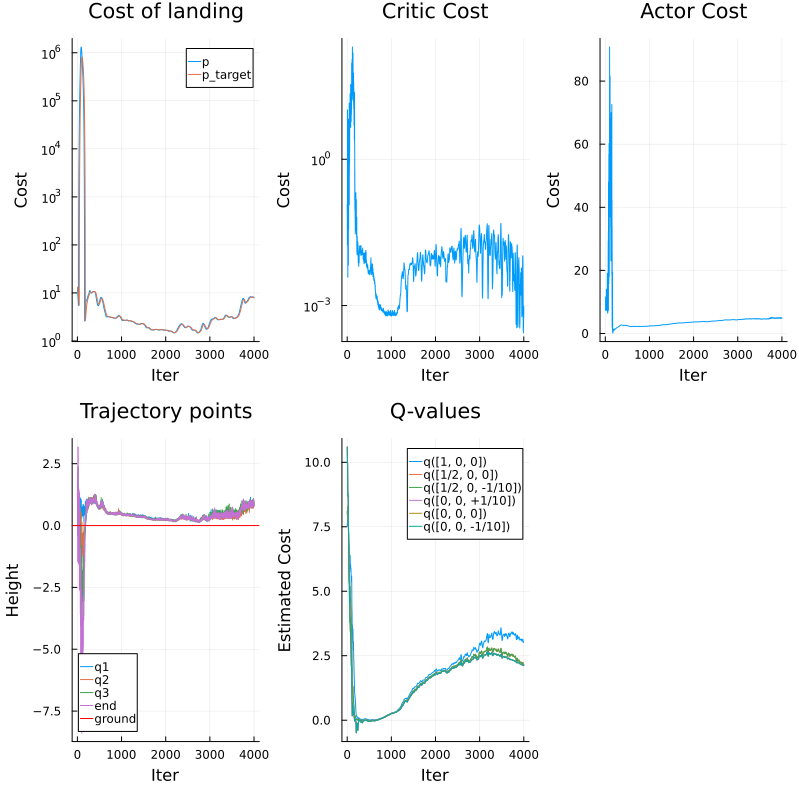

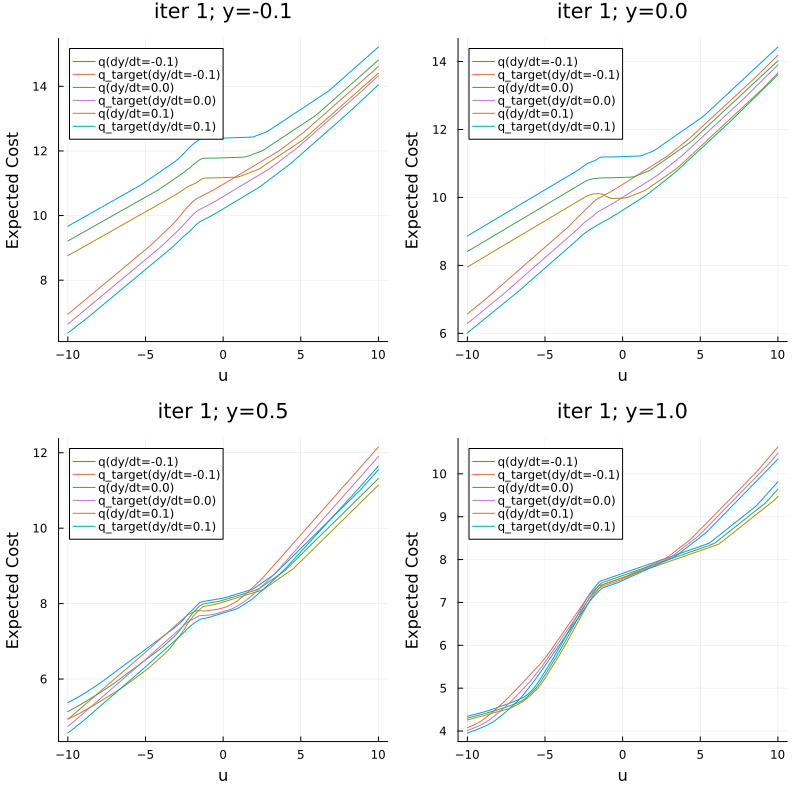

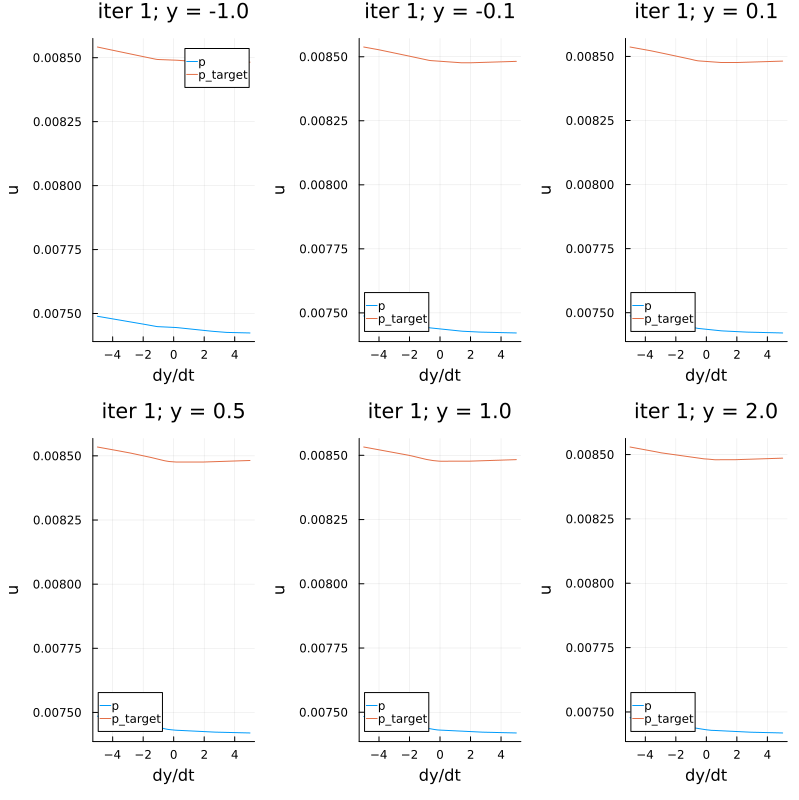

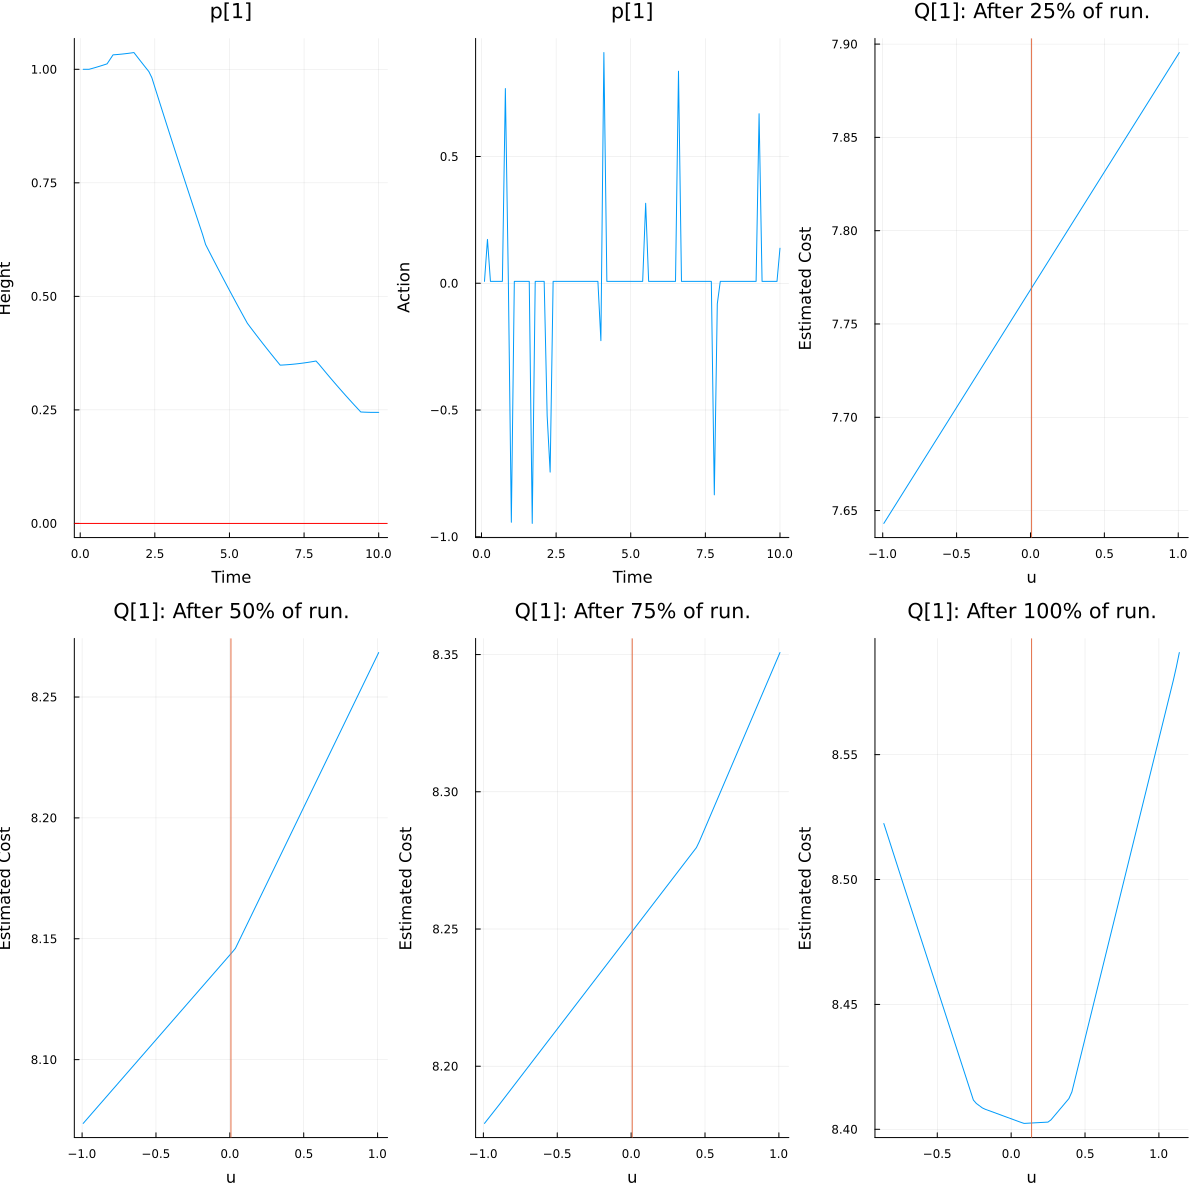

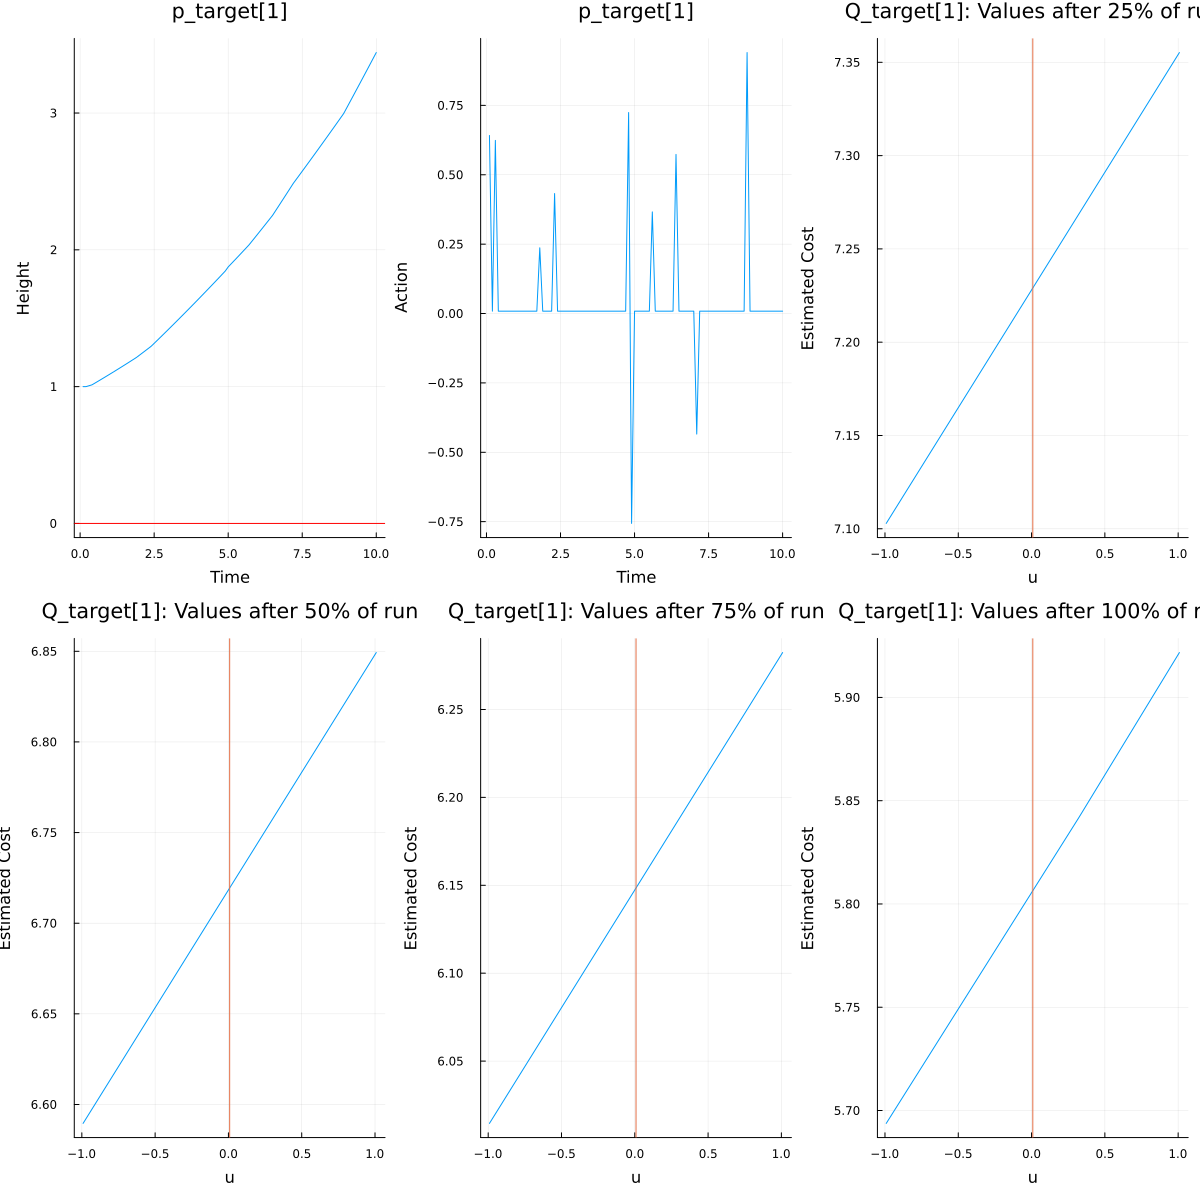

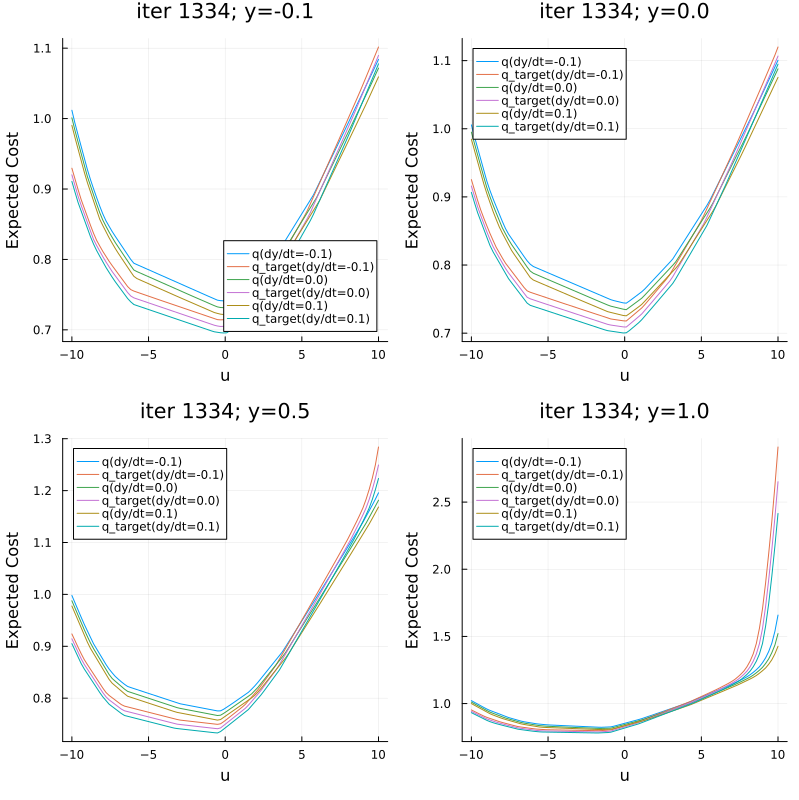

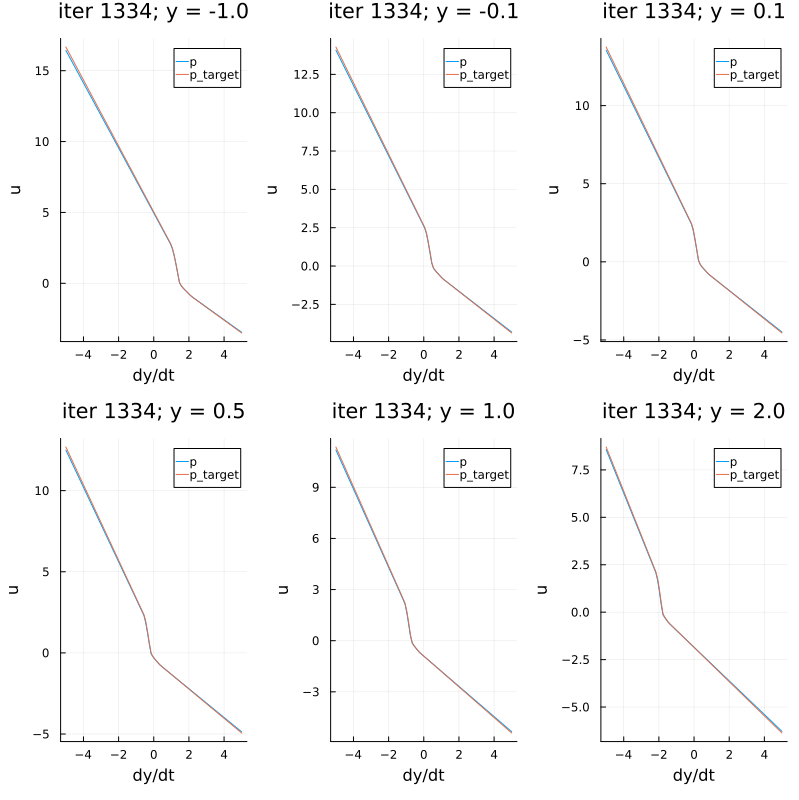

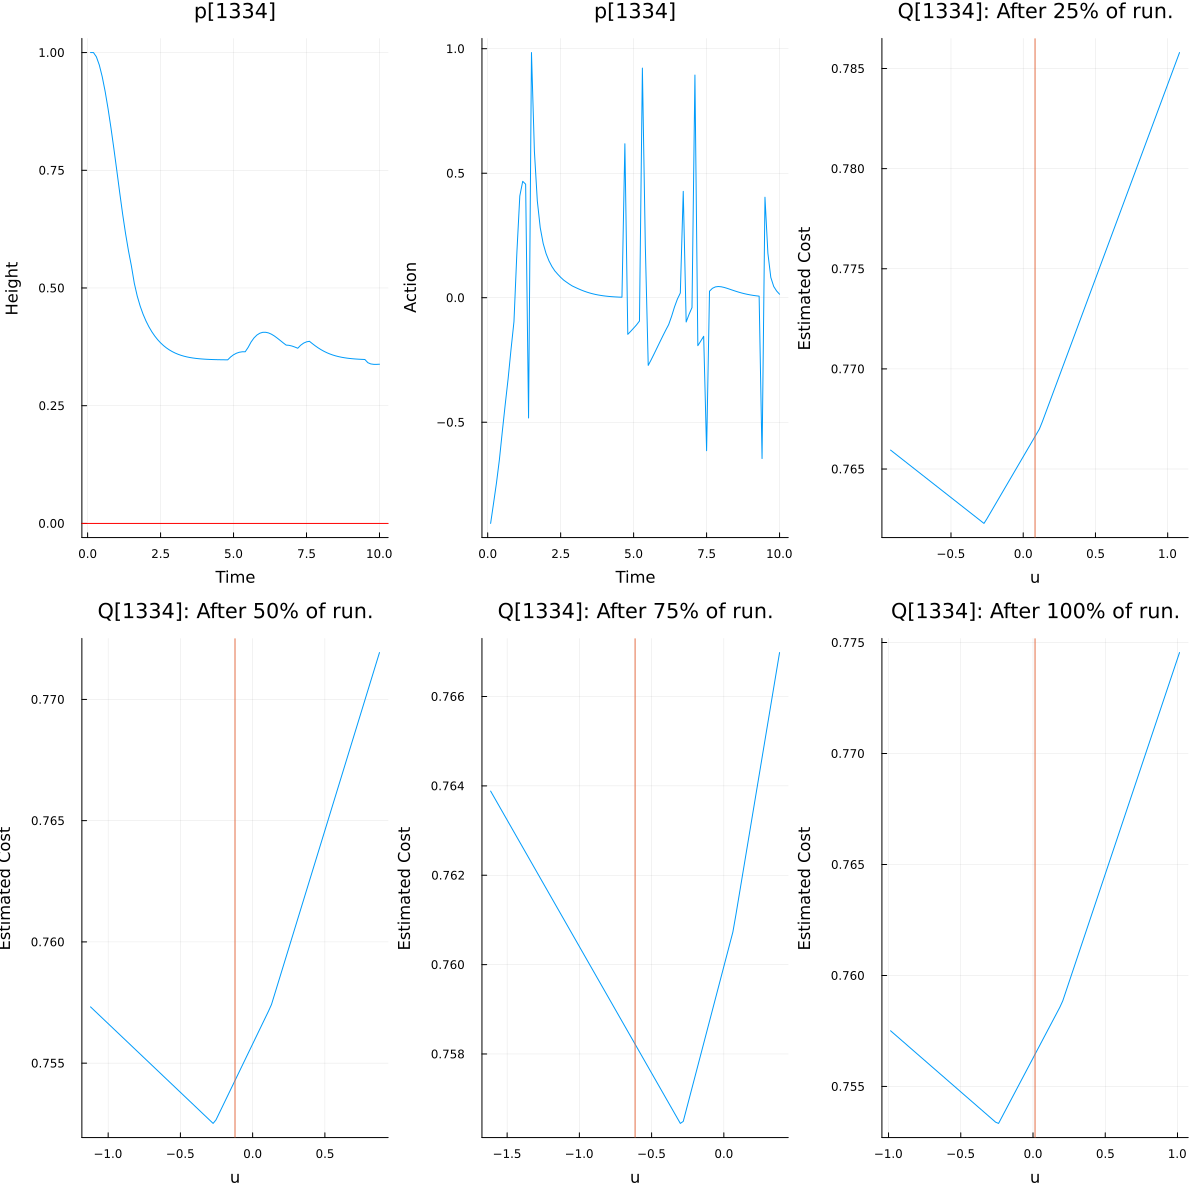

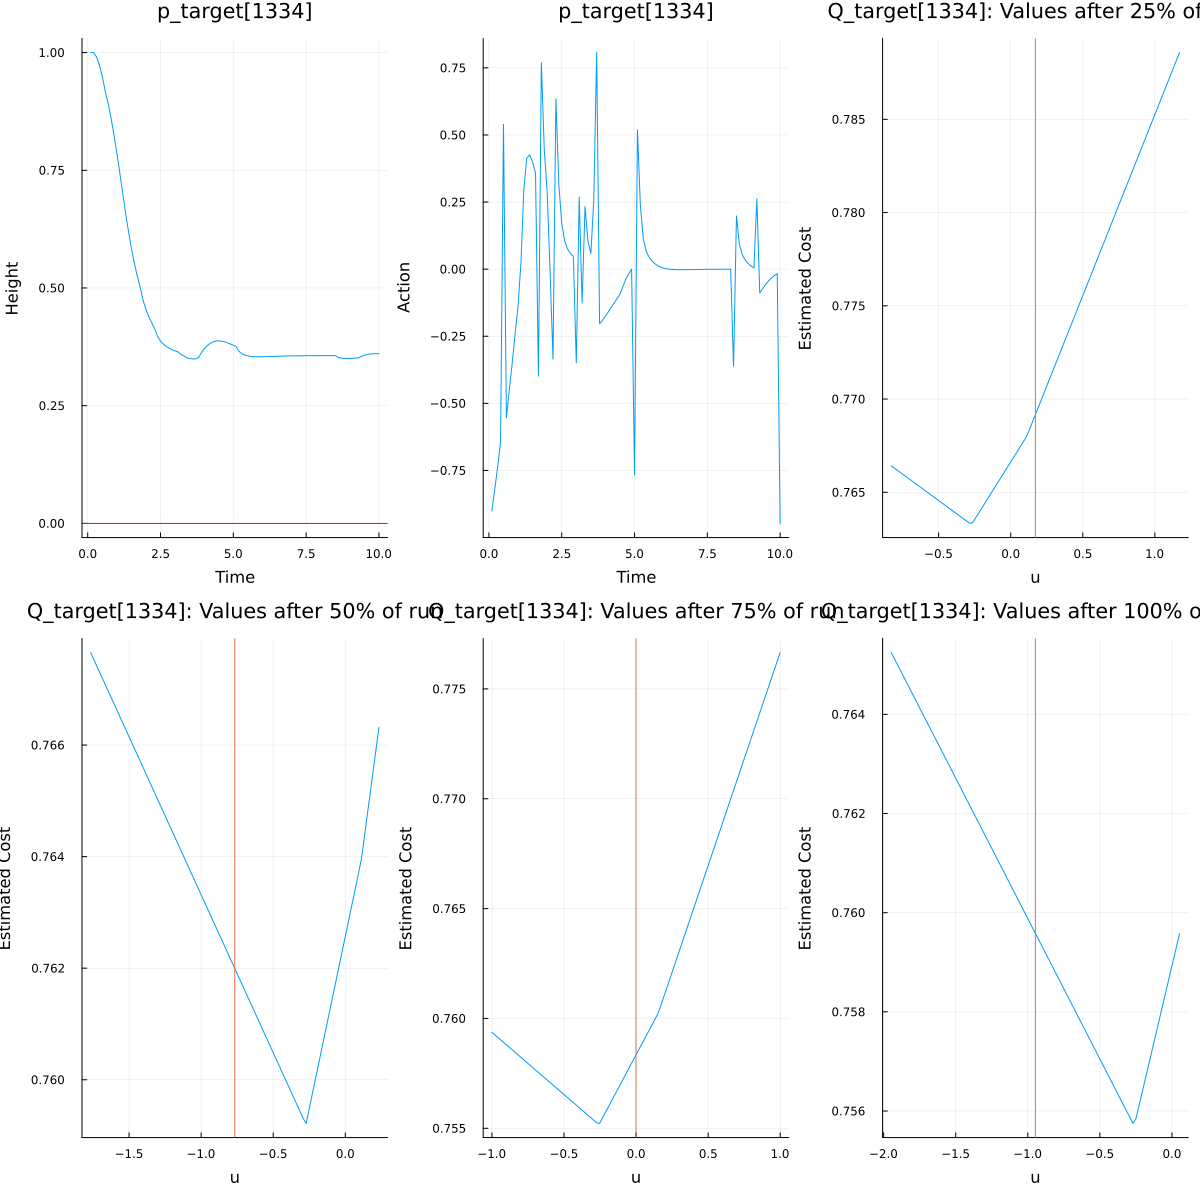

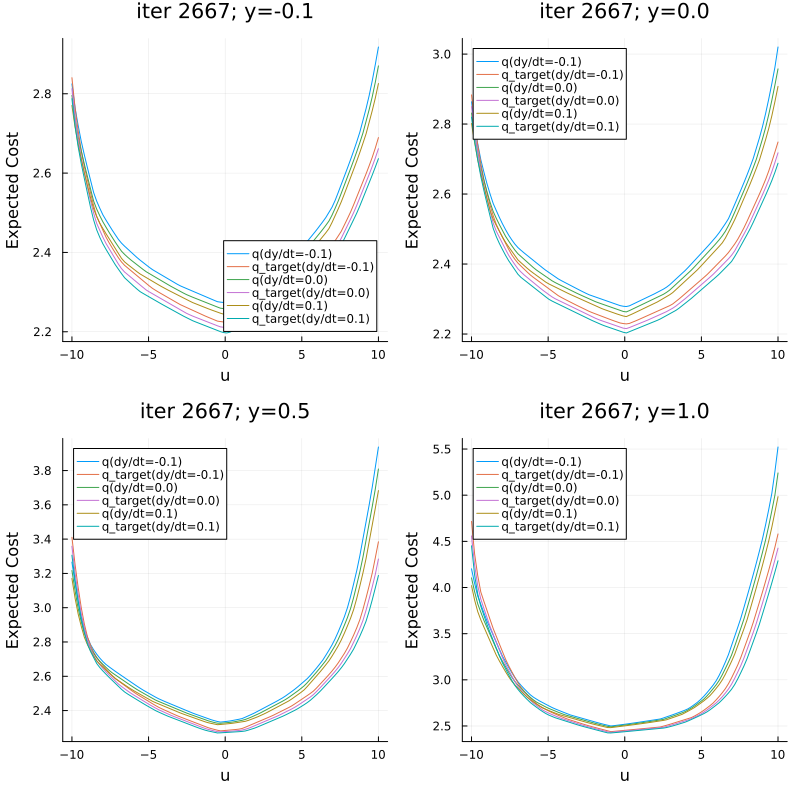

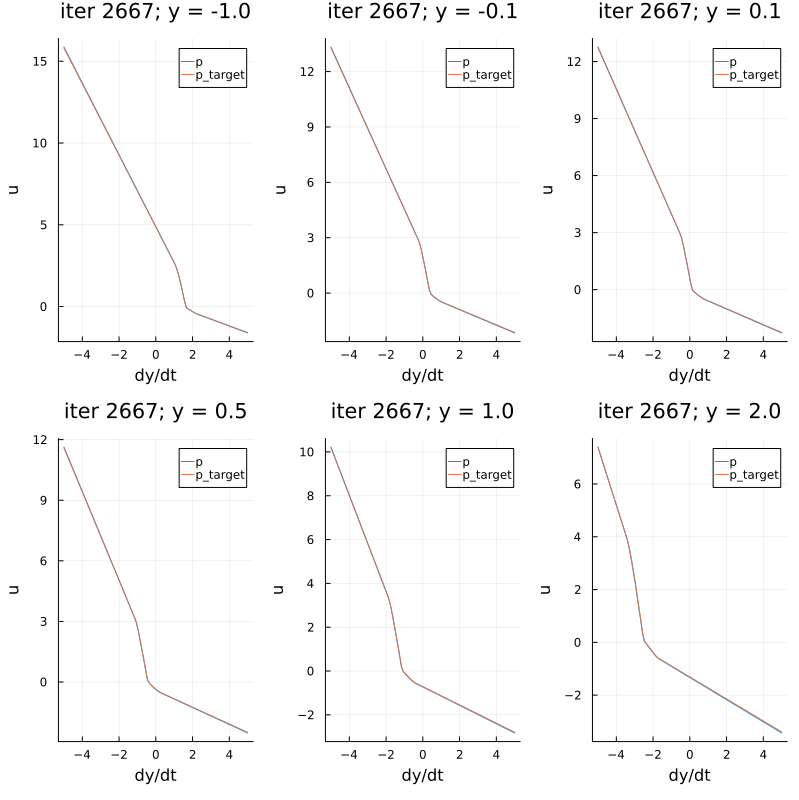

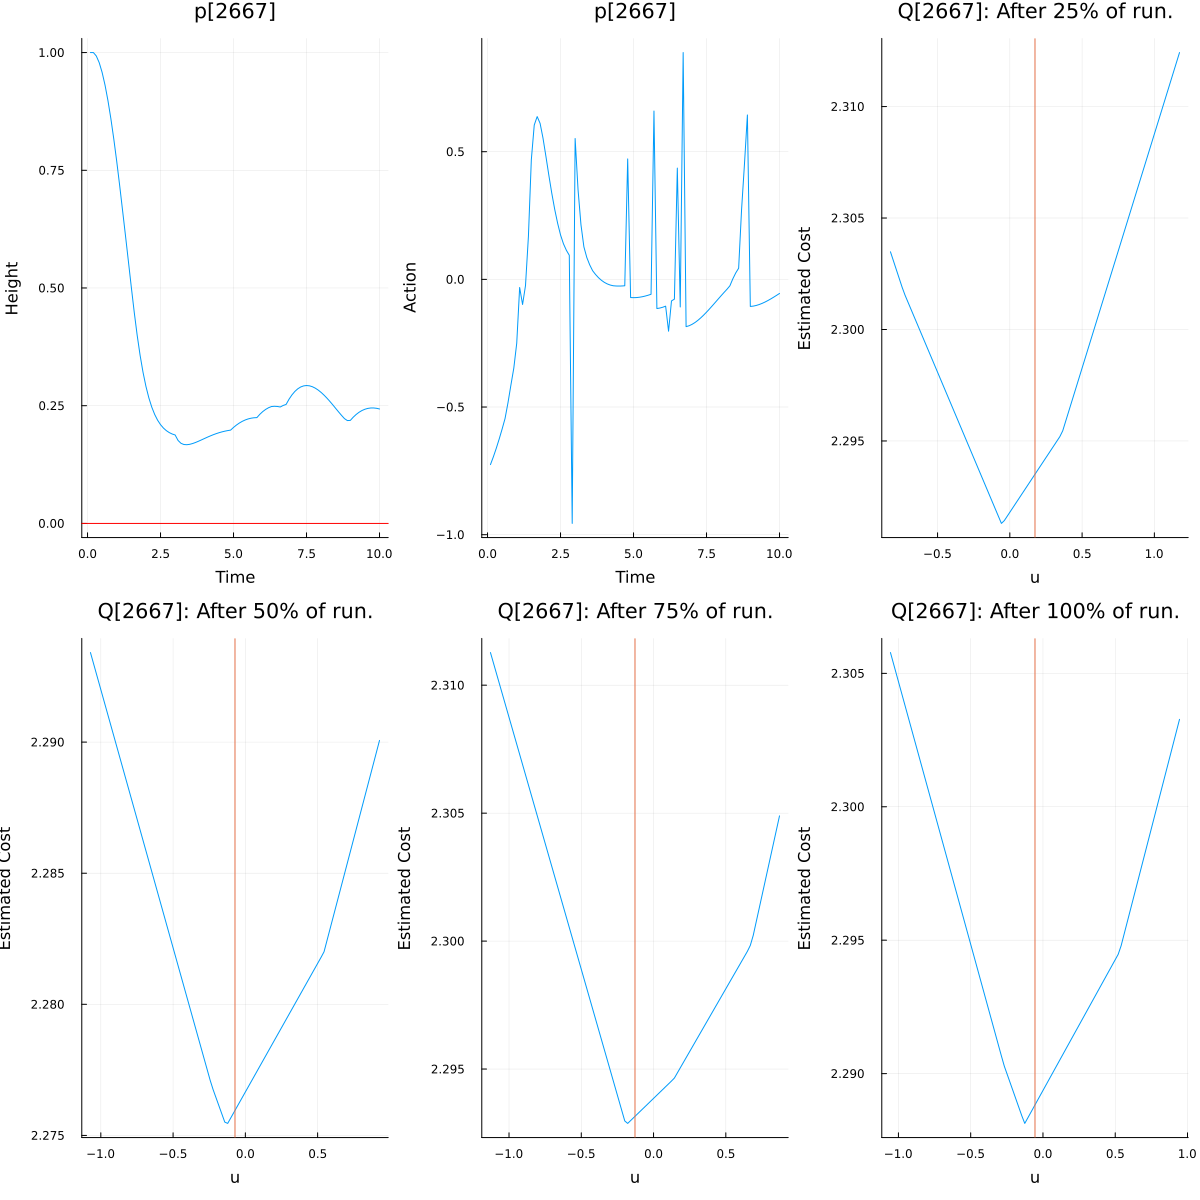

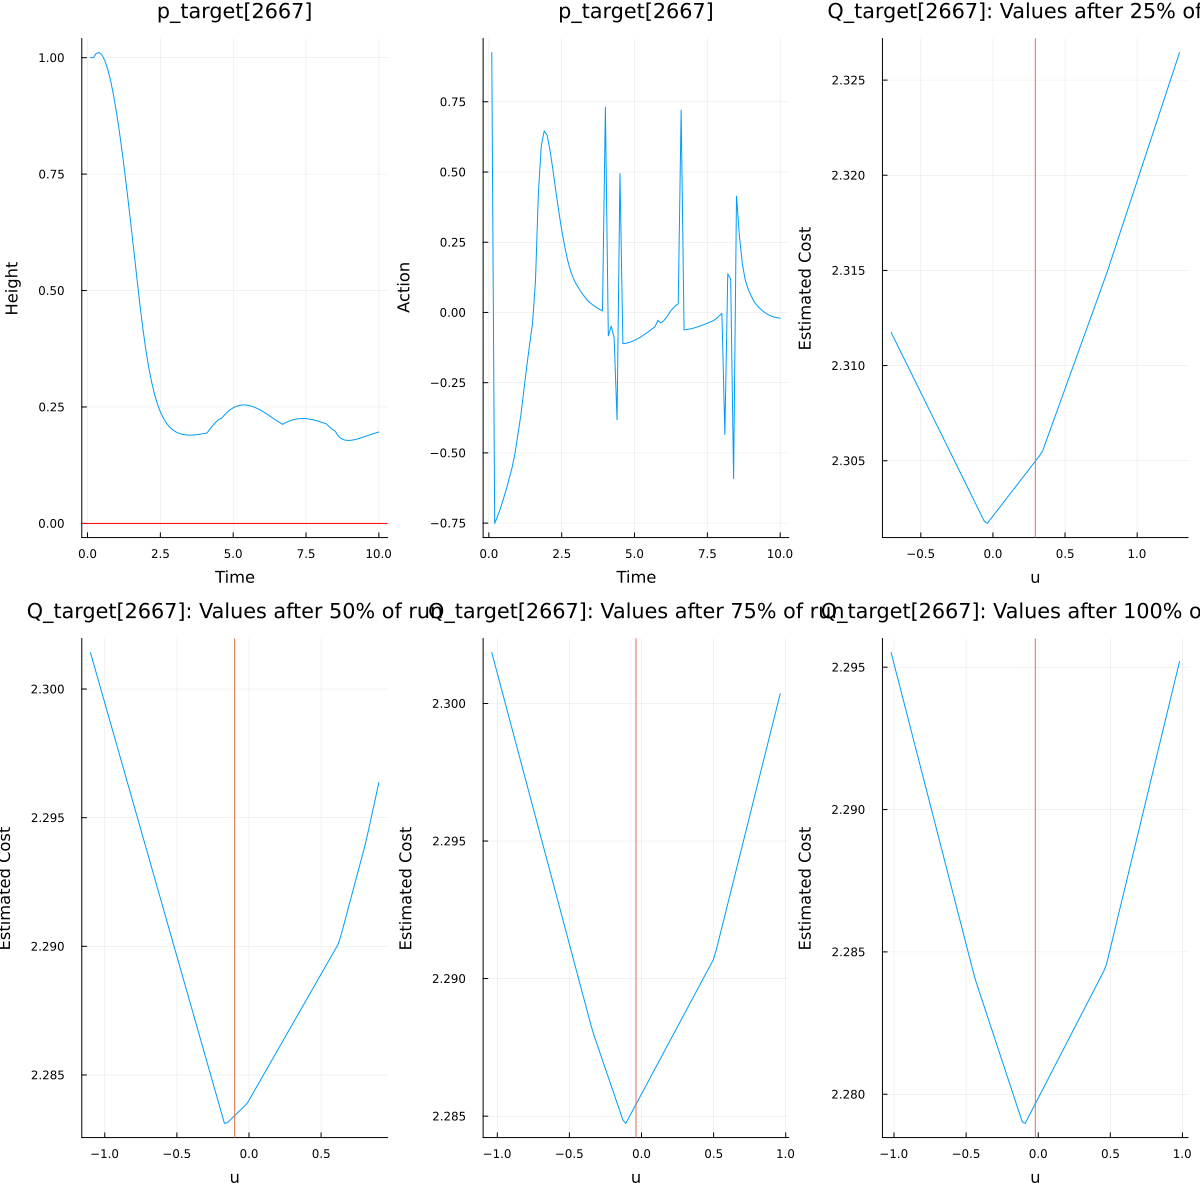

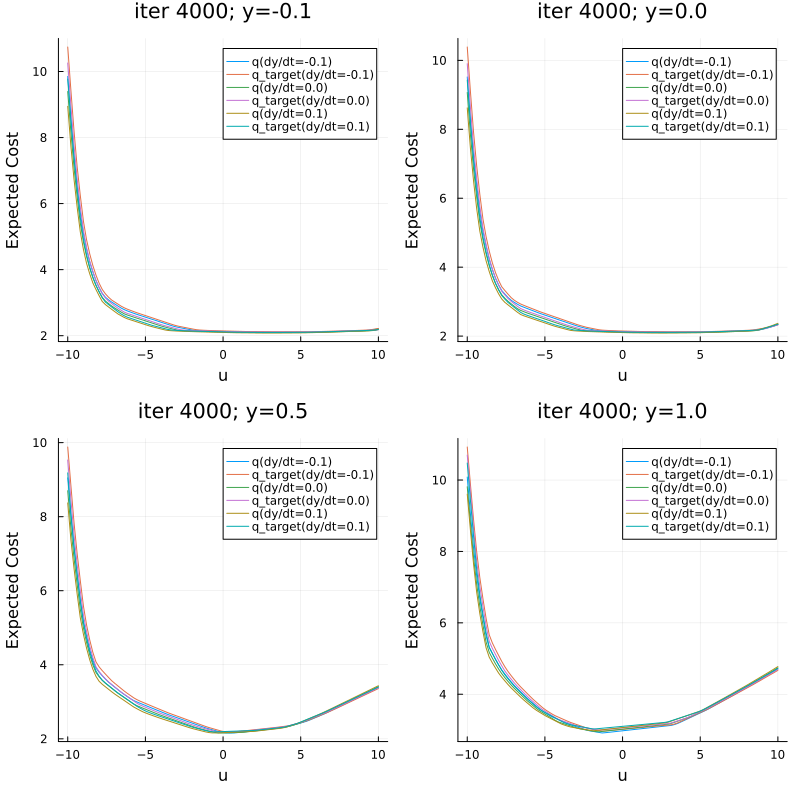

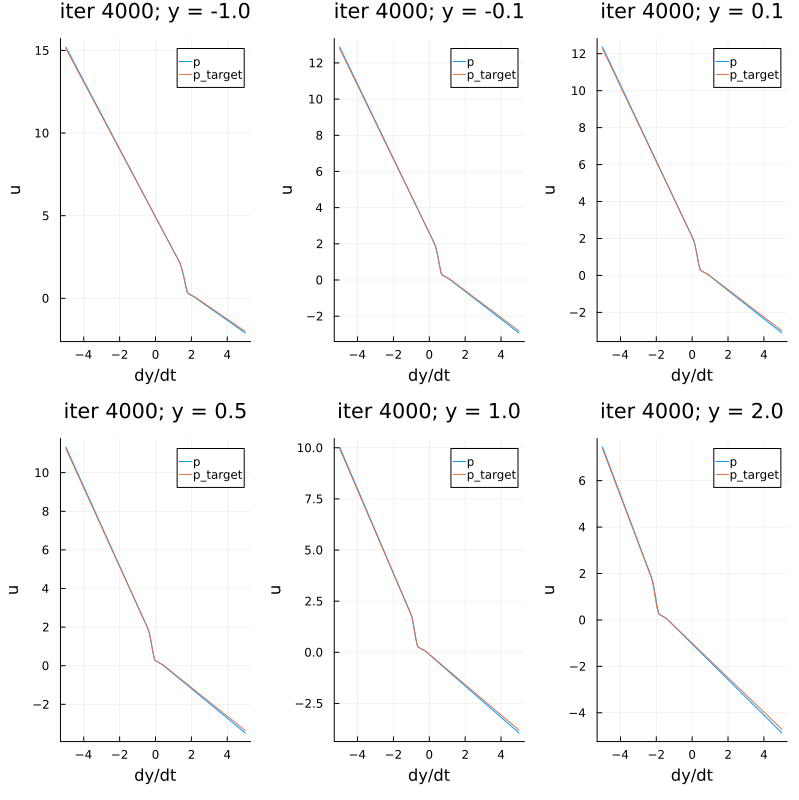

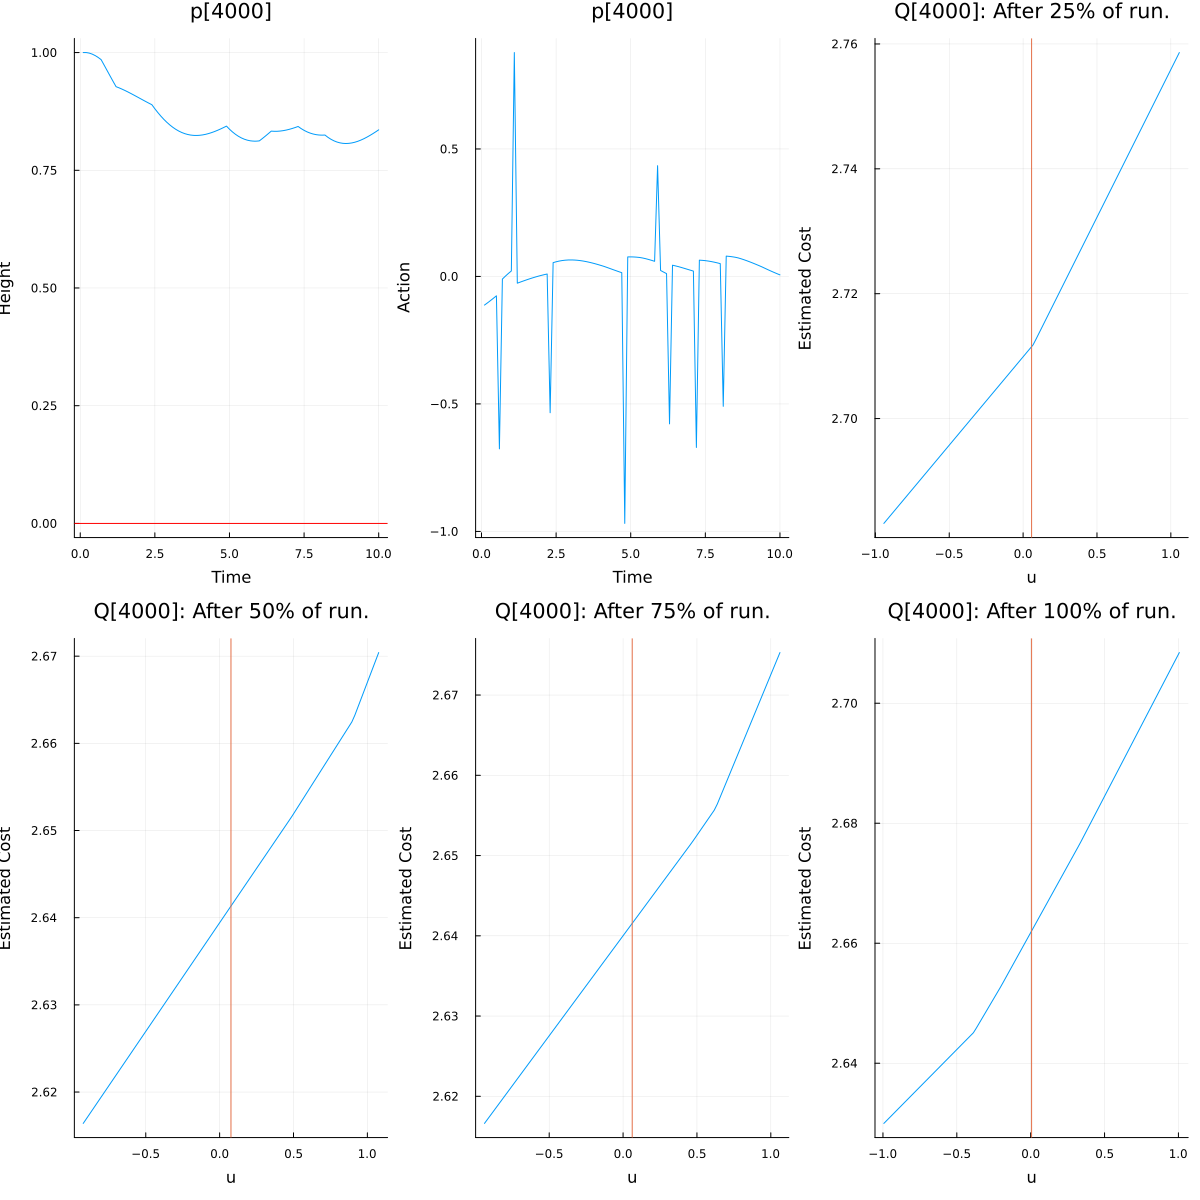

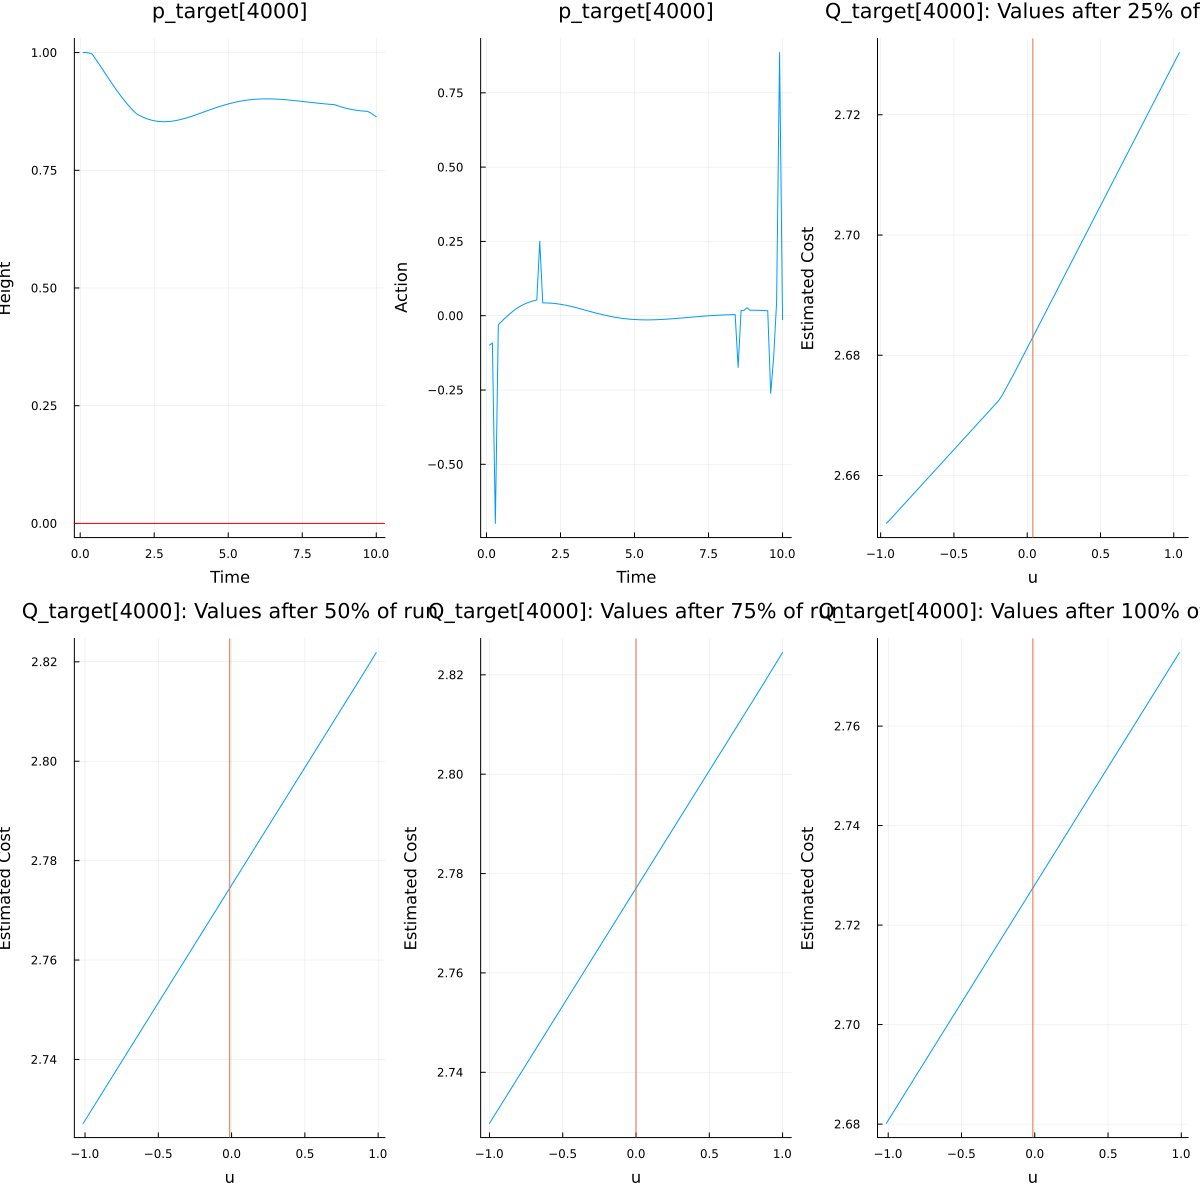

In [43]:
seed!(17)
ns = DDPG(q_layers = q_layers, n_iters = n_iters, n_steps = n_steps, critic_cost_bound = critic_cost_bound, n_critic_pre_steps = n_critic_pre_steps,  
n_samples = n_samples, replay_buffer_size = replay_buffer_size, γ = γ);
push!(nets, ns)
gen_figs(ns...)